In [ ]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [ ]:
from google.colab import drive
drive.mount("./content")

Drive already mounted at ./content; to attempt to forcibly remount, call drive.mount("./content", force_remount=True).


In [ ]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def make_simple_conv_block(in_planes, out_planes, kernel_size=3,stride=1,padding=1):
  return nn.Sequential(
      nn.Conv2d(in_planes, out_planes, kernel_size,stride=stride,padding=padding, bias=False),
      nn.BatchNorm2d(out_planes),
      nn.ReLU(inplace=True)
  )

def make_simple_deconv_block(in_planes, out_planes, kernel_size=3):
  return nn.Sequential(
      nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4,stride=2,padding=1, bias=False),
      nn.BatchNorm2d(out_planes),
      nn.ReLU(inplace=True)
  )

In [ ]:
class Reshape(nn.Module):
  def __init__(self,new_shape):
    super().__init__()
    self.new_shape = new_shape
  
  def forward(self, x):
    return x.view(self.new_shape)

In [ ]:
train_ds = torchvision.datasets.MNIST("./content/MyDrive/MachineLearning/datasets/",train=True,transform=torchvision.transforms.ToTensor())
test_ds = torchvision.datasets.MNIST("./content/MyDrive/MachineLearning/datasets/",train=False,transform=torchvision.transforms.ToTensor())

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128)

In [ ]:
latent_space = 100

In [ ]:
def train_one_epoch(generator, discriminator, train_dl, optim_generator, optim_discriminator):
  tot_generator_loss = 0
  tot_discriminator_loss = 0
  generator.train()
  discriminator.train()
  for x, _ in train_dl:
    optim_generator.zero_grad()
    optim_discriminator.zero_grad()

    real_imgs = x.to(dev)
    N, C, H, W = x.shape

    real_labels = torch.ones(N).to(dev)
    fake_labels = torch.zeros(N).to(dev)

    noise = torch.randn((N,latent_space)).to(dev)
    fake_imgs = generator(noise).detach()

    fake_pred = discriminator(fake_imgs)
    real_pred = discriminator(real_imgs)
    loss_discriminator = nn.functional.binary_cross_entropy_with_logits(fake_pred.reshape(-1), fake_labels,reduction="mean") + \
     nn.functional.binary_cross_entropy_with_logits(real_pred.reshape(-1), real_labels,reduction="mean")
    loss_discriminator.backward()
    optim_discriminator.step()

    noise = torch.randn((N,latent_space)).to(dev)
    fake_imgs = generator(noise)
    fake_pred = discriminator(fake_imgs)
    loss_generator = nn.functional.binary_cross_entropy_with_logits(fake_pred.reshape(-1), real_labels,reduction="mean")
    loss_generator.backward()
    optim_generator.step()

    tot_generator_loss += loss_generator.item()
    tot_discriminator_loss += loss_discriminator.item()
  return tot_generator_loss / len(train_dl), tot_discriminator_loss / len(train_dl)

def train(generator, discriminator, train_dl, optim_generator, optim_discriminator, epochs=10):
  for epoch in tqdm.tqdm_notebook(range(epochs)):
    generator_loss, discriminator_loss = train_one_epoch(generator, discriminator, train_dl, optim_generator, optim_discriminator)
    print(f"epoch: {epoch}, generator loss: {generator_loss}, discriminator loss: {discriminator_loss}")

In [ ]:
generator = nn.Sequential(
    nn.Linear(100,32*7*7),
    Reshape((-1,32,7,7)),
    make_simple_deconv_block(32,16),
    make_simple_deconv_block(16,1)
).to(dev)

discriminator = nn.Sequential(
    make_simple_conv_block(1,16),
    nn.MaxPool2d(2),
    make_simple_conv_block(16,32),
    nn.MaxPool2d(2),
    make_simple_conv_block(32,32),
    nn.MaxPool2d(2),
    make_simple_conv_block(32,64),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64,1)
).to(dev)

In [ ]:
optim_generator = torch.optim.SGD(generator.parameters(), lr=0.01)
optim_discriminator = torch.optim.SGD(discriminator.parameters(), lr=0.001)
train(generator, discriminator, train_dl, optim_generator, optim_discriminator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, generator loss: 2.776706504256232, discriminator loss: 0.3628058637827953
epoch: 1, generator loss: 2.7931817560625483, discriminator loss: 0.3705690341876514
epoch: 2, generator loss: 3.0095780850854763, discriminator loss: 0.29795550923548275
epoch: 3, generator loss: 3.0733959853394963, discriminator loss: 0.3107890796575592
epoch: 4, generator loss: 3.28048972642498, discriminator loss: 0.24948239915851336
epoch: 5, generator loss: 3.50813208701514, discriminator loss: 0.20601688180841618
epoch: 6, generator loss: 3.3610464105052924, discriminator loss: 0.2646335885564147
epoch: 7, generator loss: 3.576106185216639, discriminator loss: 0.1843017179495109
epoch: 8, generator loss: 3.50887727227483, discriminator loss: 0.2551260824078944
epoch: 9, generator loss: 3.558631285000394, discriminator loss: 0.2627043662580854


In [ ]:
torch.save(generator.state_dict(),"./content/MyDrive/MachineLearning/models/mnist_generator.ckpt")
torch.save(discriminator.state_dict(),"./content/MyDrive/MachineLearning/models/mnist_discriminator.ckpt")

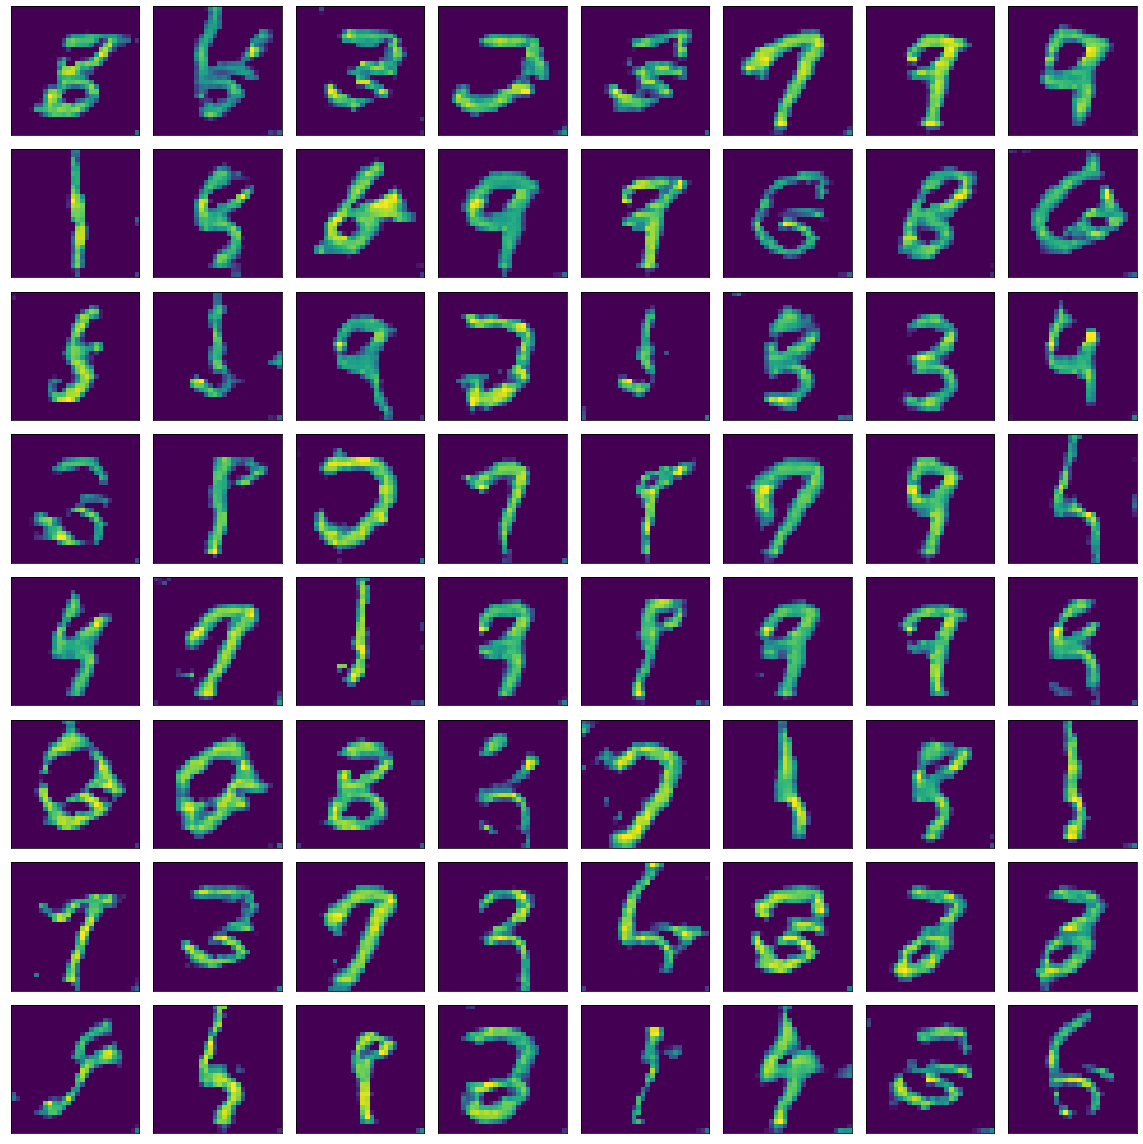

In [ ]:
generator.eval()
discriminator.eval()
sample_imgs = 64
with torch.no_grad():
  x_ = torch.randn((sample_imgs,latent_space)).to(dev) 
  o = generator(x_).cpu().detach().numpy()
  fig ,axs = plt.subplots(8,8,figsize=(16,16))
  for i in range(sample_imgs):
    axs[i//8,i%8].imshow(o[i][0])
    axs[i//8,i%8].set_xticks([])
    axs[i//8,i%8].set_yticks([])

plt.tight_layout()